In [40]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import os
import time
from imagePreprocess import getImagesVarAndMean

In [41]:
# %load_ext blackcellmagic
# todo custom loss to bump up brigtness
dataDir = "data/resized/"
biggerNet = True
depthMultiplier = 2
initializer = 'he_normal'#'glorot_uniform' ##
activation = 'relu'#LeakyReLU(alpha=0.3)
finalActivation = 'relu' # 'sigmoid'
normalize = finalActivation == 'sigmoid' # normalizing output hinders this training
colorspace = ['lab','rgb','hsv'][0]
rgb = colorspace == 'rgb'
lab = colorspace == 'lab'

In [159]:
def showHsv(img):    
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif lab:
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
#     hue = K.square(huePred - hueTrue) 
    
    hue2 = K.minimum(K.square(huePred - hueTrue), 
                    K.minimum(K.square(huePred - hueTrue + maxHue), 
                              K.square(huePred - hueTrue - maxHue)))
    #hue = K.minimum((huePred + 181 - hueTrue) % 181, (hueTrue + 181 - huePred) % 181) #3
    #hue = K.square( (huePred - hueTrue) % 181 )
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)*2 + 1 # was /2
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    #hue = hue  + 1 / (huePred + 1)
    #hue2 = hue2  + 1 / (huePred + 1)
    return K.concatenate([hue2, saturation], axis=-1) # predictedHue was 0 when order is reversed

def saturationLoss(yTrue, yPred):
    multiplier = 1 / K.sqrt(K.abs( (yPred[...,0] - 128) * (yPred[...,1] - 128)) +0.1)
    a =  K.square(yTrue[...,0] - yPred[...,0]) 
    b =  K.square(yTrue[...,1] - yPred[...,1]) 
    return K.concatenate([a*multiplier, b*multiplier], axis=-1)
    
    

In [136]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB if lab else cv2.COLOR_BGR2HSV)
print(hsv.shape)
print('''LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.''')
h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255
(1008, 1600, 3)
LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.


In [45]:
def loadImgHsv(path):
    '''
    returns X - value
            Y - (hue, saturation) or (blue, green, red) or (L, A, B)
    '''
    img_in = cv2.imread(path)
    if lab:
        LAB = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(LAB)
        return l, np.dstack((a,b))
        
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    if rgb:
        b,g,r = cv2.split(img_in)
        Y = np.dstack((b,g,r))
    else:
        Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, var, mean, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.hsstd = np.sqrt(var[...,:2])
        self.hsmean = mean[...,:2]
        self.vstd = np.sqrt(var[...,2])
        self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd # it doesn't like standardization 
        X = np.expand_dims(X, axis=len(X.shape))
        if normalize:
            Y[...,0] /= 180 # was [0] by mistake
            Y[...,1] /= 255
#             X /= 255
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [172]:
params = {'dim': (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 3 if rgb else 2,
          'shuffle': True}
data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.8 # 0.1
trainSize = int(len(data_IDs)*trainSplitPercent)
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSplitPercent = 0.002 # 0.02
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))


training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)
print(params['mean'].shape)

dataset size 202599
train len 162079
val len 405
(32, 128, 128, 2)
(128, 128, 3)


In [52]:
def createModel(input_shape, bigger, mul, initializer, activation, finalActivation):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = activation, padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge7)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(3 if rgb else 2, 1, activation = finalActivation, padding = 'same', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss='mean_squared_error',#customLoss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 128, 128, 32) 320         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 128, 128, 32) 9248        conv2d_171[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_172[0][0]                 
__________________________________________________________________________________________________
conv2d_173

In [ ]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
countEpochs = 1
#Compiling a model does not modify its state. Weights after compilation are the same as before compilation.
predictFromImage(f'data/resized/{trainSize:06}.jpg', True)

In [182]:
# model.load_weights('data/unet_bigger_mul1_glorot_uniform13-05-2019-00-47-35.h5')
# model.save_weights('lab_big_train_set.h5')
# countEpochs = 1
# model.load_weights('good_lab_trained8epochs.h5')

In [171]:
# model.compile(loss='mae',
#                   optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
#                   metrics=['mae','mse'])

In [180]:
for i in range(1,3):
    #start_time = time.time()
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    #elapsed_time = time.time() - start_time
    #print(f"epochs:{countEpochs}, elapsed time:{elapsed_time}")
#     predictFromImage(f'data/resized/{i+18:06}.jpg', True)

Epoch 18/18
5064/5064 [==============================] - 1293s 255ms/step - loss: 6.3344 - mean_absolute_error: 6.3344 - mean_squared_error: 104.7041 - val_loss: 6.2313 - val_mean_absolute_error: 6.2313 - val_mean_squared_error: 99.5251
Epoch 19/19
5064/5064 [==============================] - 1294s 256ms/step - loss: 6.3018 - mean_absolute_error: 6.3018 - mean_squared_error: 104.0506 - val_loss: 6.1766 - val_mean_absolute_error: 6.1766 - val_mean_squared_error: 98.8500


In [97]:
def mapOutOfGreen(m):
    '''maps green colors into others'''
    minGreen, maxGreen = 42, 63
    target = 160
    r = np.copy(m)
    r[(r >= minGreen) & (r<=maxGreen)] = (r[(r >= minGreen) & (r<=maxGreen)] - minGreen) +  target
    # smoother transition
    d = 7
    lower = minGreen - d
    sel = r[(r < minGreen) & (r>= lower)]
    r[(r < minGreen) & (r>= lower)] = (sel - lower) /d * (target - lower) + sel

    higher = maxGreen + d
    sel = r[(r > maxGreen) & (r<= higher)]
    r[(r > maxGreen) & (r<= higher)] = (sel - higher) /d * (target - higher) + sel
    return r

def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    if rgb:
        RGB, v = hs[0], v[0,...,0]
        print('rgb.shape',RGB.shape)
        img = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)
    else:
        hs, v = hs[0], v[0,...,0]
        #print('hs:',hs.shape)
        h, s = hs[...,0], hs[...,1]
        #h = mapOutOfGreen(h)
        #print('h',h.shape,'s',s.shape,'v',v.shape)
        #print(h.dtype, s.dtype, v.dtype)
        hsv = cv2.merge([v,h,s] if lab else [h,s,v] )
        img = cv2.cvtColor(hsv, cv2.COLOR_LAB2RGB if lab else cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
        
    f, axarr = plt.subplots(1,4 + 1*rgb, figsize=(15,15))
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(img)
    titles = ['blue', 'green', 'red','value'] if rgb else ['A','B','L'] if lab else ['hue', 'saturation', 'value']
    for i in range(3 if rgb else 2,-1,-1):
        if rgb:
            pic = RGB[:,:,i] if i < 3 else v
        elif lab:
            pic = hsv[:,:,-i-1]
        else:
            pic = hsv[:,:,i]
        axarr[1+i].title.set_text(titles[i])
        axarr[1+i].set_xticks([])
        axarr[1+i].set_yticks([])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    inX, inY = loadImgHsv(img )
    inX, inY = inX[None,...,None], inY[None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)
    if not rgb:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print('hue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
        print('sat:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    else:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print('red:',predY[...,2].min(), predY[...,2].max(), predY[...,2].mean() )
        print('green:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
        print('blue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    if normalize:
        # hue and sat [0,1] -> their range
        predY[...,0] *= 180
        predY[...,1] *= 255
    else:
        if not rgb:
            predY[...,0] = predY[...,0] % 181
        else:
            predY = np.minimum(predY, 255)
        predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    if not rgb:
        hue = predY[...,0]
        print('hue uint8',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        predictFromImage(f'data/resized/{i:06}.jpg', True)

countEpochs 19
predy 127.65713 156.28036 138.57828 (1, 128, 128, 2)
hue: 128.13095 154.88599 137.92477
sat: 127.65713 156.28036 139.23175
predy uint8 127 156 138.07919311523438
hue uint8 128 154 137.42559814453125


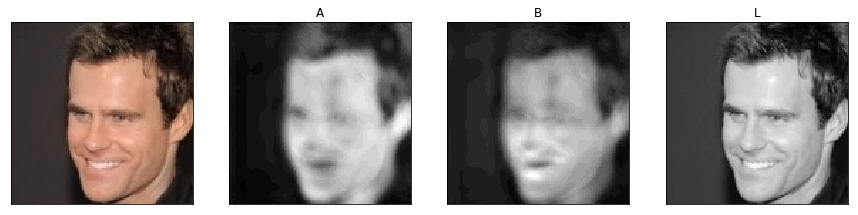

predy 127.70889 156.13628 139.11856 (1, 128, 128, 2)
hue: 127.70889 154.48077 137.53036
sat: 128.1278 156.13628 140.70674
predy uint8 127 156 138.62423706054688
hue uint8 127 154 137.0406494140625


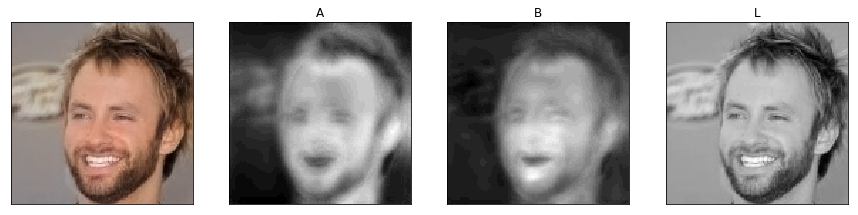

predy 126.452415 157.51768 139.06053 (1, 128, 128, 2)
hue: 126.452415 157.51768 136.06877
sat: 128.06903 153.47942 142.0523
predy uint8 126 157 138.55975341796875
hue uint8 126 157 135.56689453125


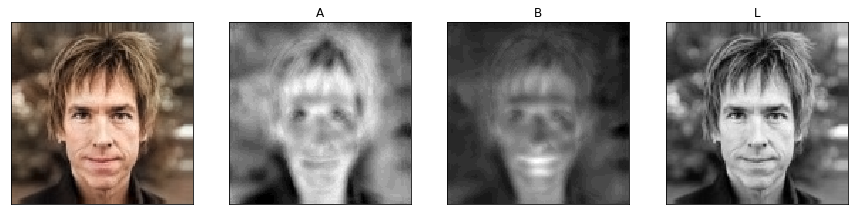

predy 127.70062 157.9331 140.45267 (1, 128, 128, 2)
hue: 127.70062 157.2115 137.26718
sat: 127.92761 157.9331 143.63817
predy uint8 127 157 139.95870971679688
hue uint8 127 157 136.77166748046875


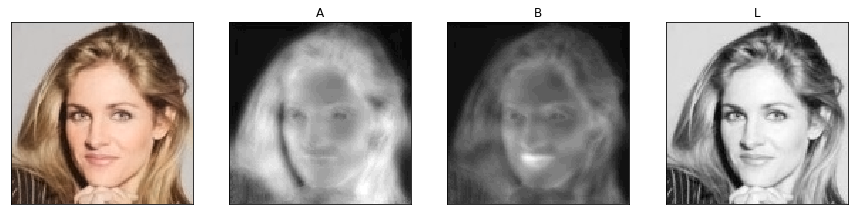

predy 128.16368 157.89137 140.83963 (1, 128, 128, 2)
hue: 128.16368 157.89137 138.09659
sat: 129.50188 155.82355 143.58267
predy uint8 128 157 140.34091186523438
hue uint8 128 157 137.59808349609375


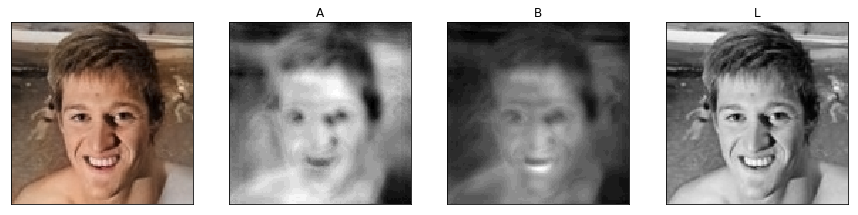

predy 123.565674 152.03648 133.4245 (1, 128, 128, 2)
hue: 125.72271 148.06314 132.82379
sat: 123.565674 152.03648 134.02524
predy uint8 123 152 132.92398071289062
hue uint8 125 148 132.3271484375


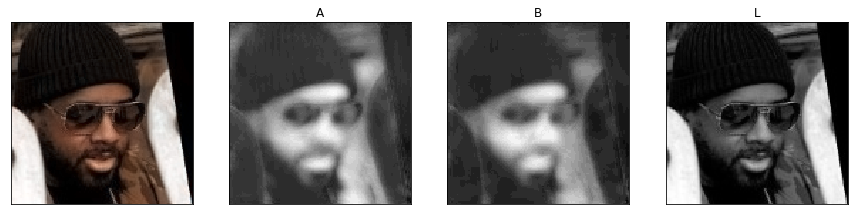

predy 126.20881 158.10246 136.4791 (1, 128, 128, 2)
hue: 127.47936 158.10246 135.19904
sat: 126.20881 157.50409 137.75916
predy uint8 126 158 135.99615478515625
hue uint8 127 158 134.71728515625


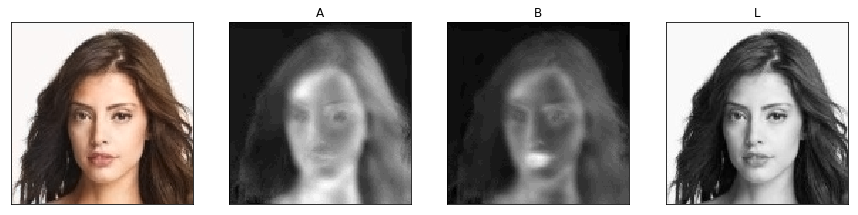

predy 126.016365 163.04237 137.63882 (1, 128, 128, 2)
hue: 126.016365 163.04237 135.3876
sat: 126.79344 153.86493 139.89006
predy uint8 126 163 137.13629150390625
hue uint8 126 163 134.881591796875


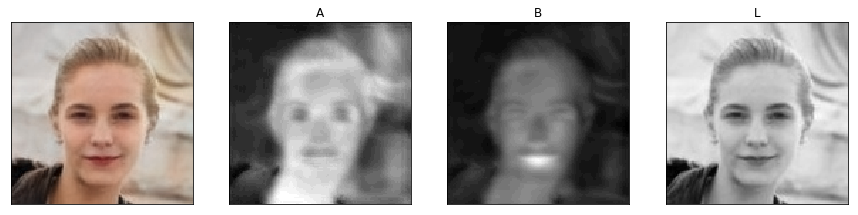

predy 125.98902 159.52481 136.97873 (1, 128, 128, 2)
hue: 125.98902 159.52481 135.22214
sat: 127.57501 156.81677 138.73532
predy uint8 125 159 136.47756958007812
hue uint8 125 159 134.72369384765625


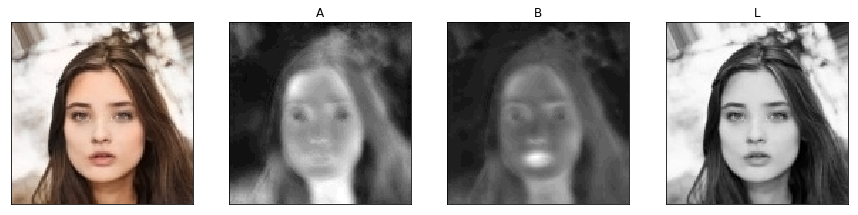

predy 125.09672 159.51697 135.76027 (1, 128, 128, 2)
hue: 126.44272 159.51697 135.32135
sat: 125.09672 159.44603 136.19919
predy uint8 125 159 135.24139404296875
hue uint8 126 159 134.81793212890625


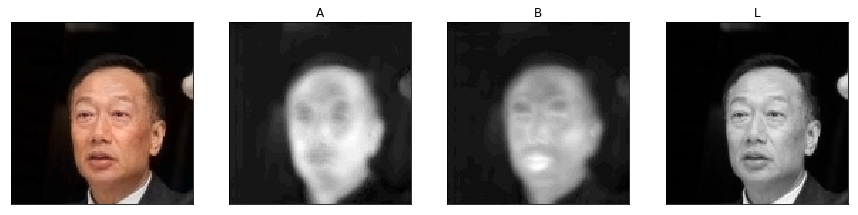

predy 125.947495 160.29955 138.59276 (1, 128, 128, 2)
hue: 125.947495 160.29955 136.39369
sat: 127.18319 160.17601 140.79182
predy uint8 125 160 138.09100341796875
hue uint8 125 160 135.89501953125


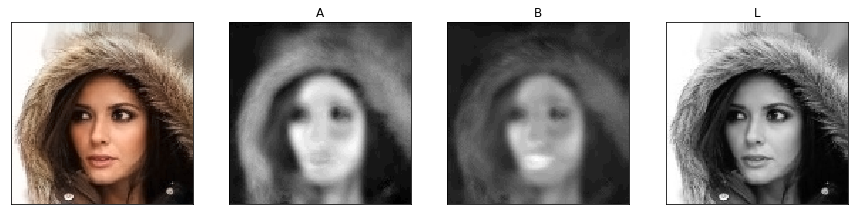

predy 128.11032 161.28818 139.95642 (1, 128, 128, 2)
hue: 128.11032 152.16652 137.76442
sat: 128.23695 161.28818 142.14839
predy uint8 128 161 139.4534912109375
hue uint8 128 152 137.260498046875


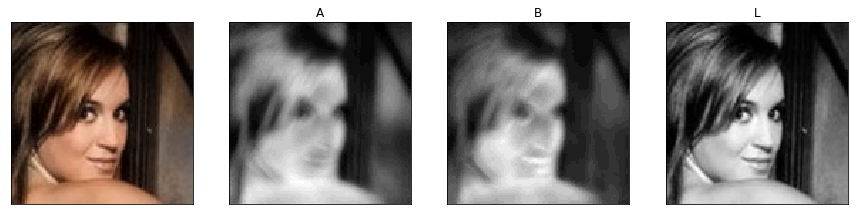

predy 126.91585 157.13757 136.48166 (1, 128, 128, 2)
hue: 128.5184 157.13757 135.50381
sat: 126.91585 157.05646 137.4595
predy uint8 126 157 135.98672485351562
hue uint8 128 157 135.0081787109375


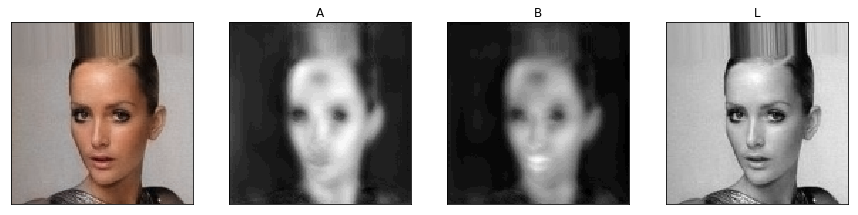

predy 125.65847 159.82591 137.27646 (1, 128, 128, 2)
hue: 126.630974 159.82591 135.44995
sat: 125.65847 156.58939 139.10297
predy uint8 125 159 136.78558349609375
hue uint8 126 159 134.960693359375


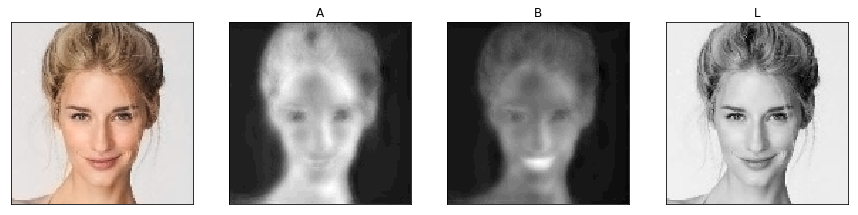

predy 126.99206 154.14433 134.79099 (1, 128, 128, 2)
hue: 127.41739 153.80434 134.0151
sat: 126.99206 154.14433 135.56686
predy uint8 126 154 134.2783203125
hue uint8 127 153 133.49932861328125


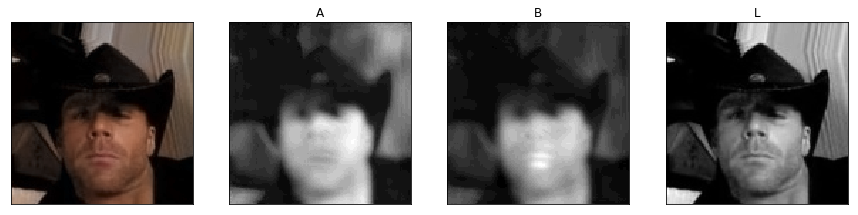

predy 126.125854 157.94014 142.31282 (1, 128, 128, 2)
hue: 127.076675 157.13803 139.46254
sat: 126.125854 157.94014 145.16312
predy uint8 126 157 141.80462646484375
hue uint8 127 157 138.953369140625


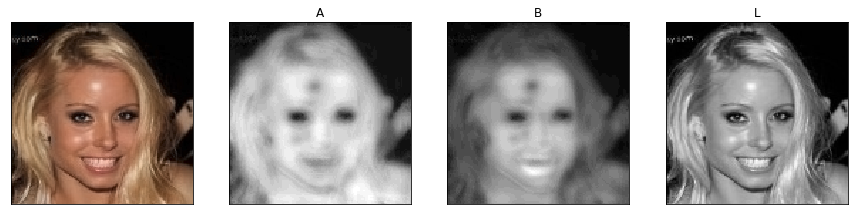

predy 124.51254 156.18199 137.56297 (1, 128, 128, 2)
hue: 126.991165 151.01385 136.2056
sat: 124.51254 156.18199 138.92036
predy uint8 124 156 137.05825805664062
hue uint8 126 151 135.70086669921875


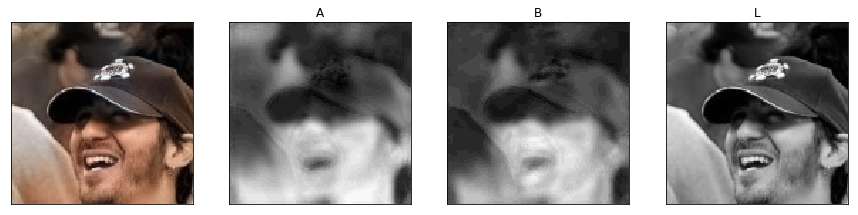

predy 127.54802 159.75569 139.17569 (1, 128, 128, 2)
hue: 127.54802 155.73273 137.61403
sat: 127.75993 159.75569 140.73735
predy uint8 127 159 138.6834716796875
hue uint8 127 155 137.12628173828125


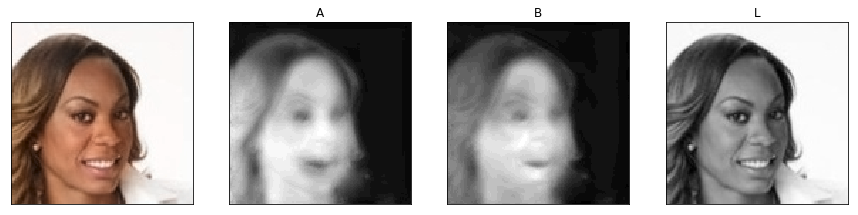

predy 127.06488 160.50583 135.84328 (1, 128, 128, 2)
hue: 127.84565 156.44978 134.91699
sat: 127.06488 160.50583 136.76956
predy uint8 127 160 135.34420776367188
hue uint8 127 156 134.4190673828125


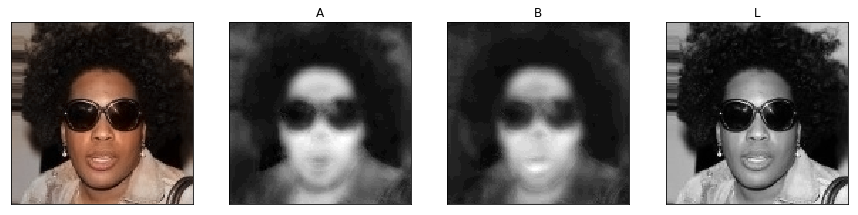

predy 126.67058 160.56 140.01932 (1, 128, 128, 2)
hue: 126.67058 160.56 136.86166
sat: 127.65256 159.43507 143.17697
predy uint8 126 160 139.51629638671875
hue uint8 126 160 136.36016845703125


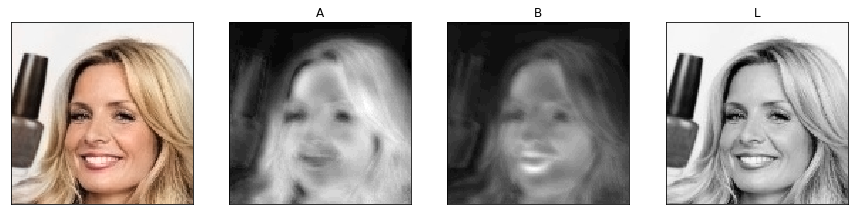

predy 129.84277 159.32076 138.75577 (1, 128, 128, 2)
hue: 129.84277 157.01236 137.10701
sat: 129.99156 159.32076 140.40453
predy uint8 129 159 138.25686645507812
hue uint8 129 157 136.61138916015625


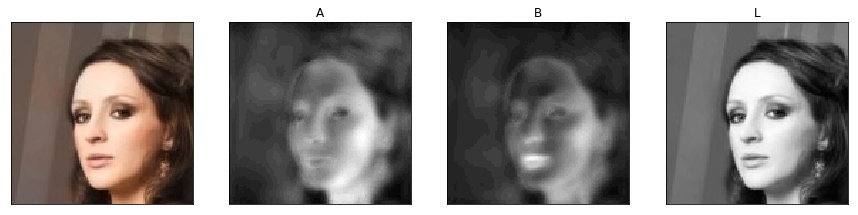

predy 127.44982 160.33731 139.56097 (1, 128, 128, 2)
hue: 127.44982 159.32611 136.0127
sat: 127.61339 160.33731 143.10924
predy uint8 127 160 139.0738525390625
hue uint8 127 159 135.52484130859375


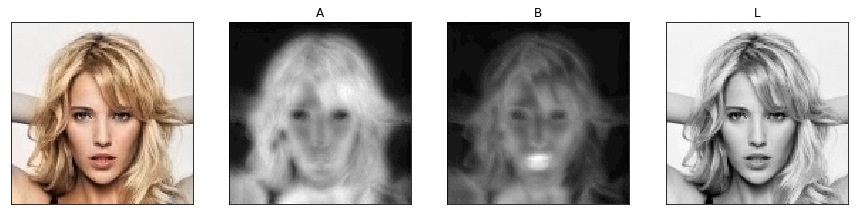

predy 126.669945 160.48988 137.53189 (1, 128, 128, 2)
hue: 126.669945 160.48988 135.9025
sat: 126.69568 155.34544 139.16129
predy uint8 126 160 137.03237915039062
hue uint8 126 160 135.40081787109375


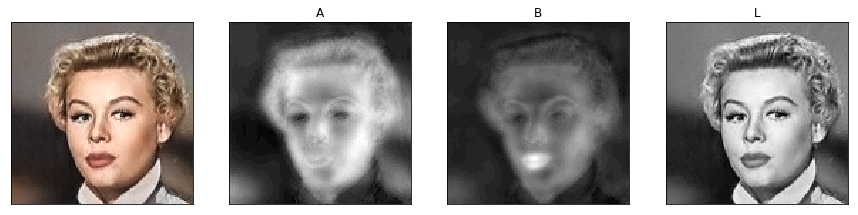

predy 125.80911 152.74236 132.7849 (1, 128, 128, 2)
hue: 127.596985 145.81026 132.65576
sat: 125.80911 152.74236 132.914
predy uint8 125 152 132.28936767578125
hue uint8 127 145 132.1602783203125


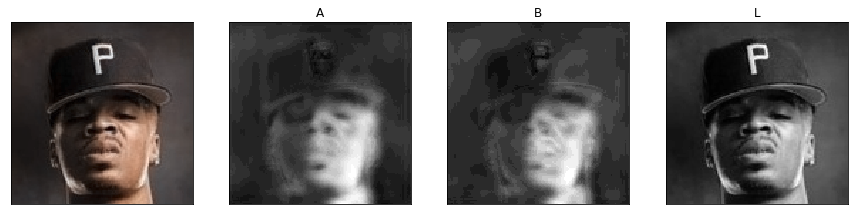

predy 122.29583 155.72784 136.67873 (1, 128, 128, 2)
hue: 125.53498 153.96814 136.11674
sat: 122.29583 155.72784 137.24069
predy uint8 122 155 136.18121337890625
hue uint8 125 153 135.61767578125


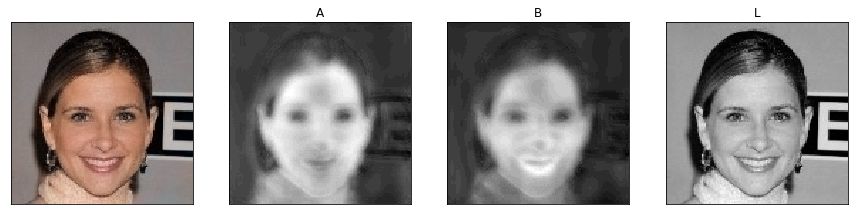

predy 125.43977 154.86554 138.10747 (1, 128, 128, 2)
hue: 125.43977 154.86554 135.48973
sat: 127.00051 154.27797 140.72522
predy uint8 125 154 137.605712890625
hue uint8 125 154 134.98443603515625


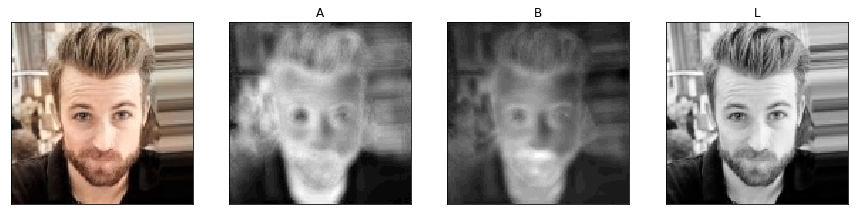

predy 127.17128 154.76096 133.9248 (1, 128, 128, 2)
hue: 127.42361 149.99446 133.169
sat: 127.17128 154.76096 134.6806
predy uint8 127 154 133.46221923828125
hue uint8 127 149 132.69793701171875


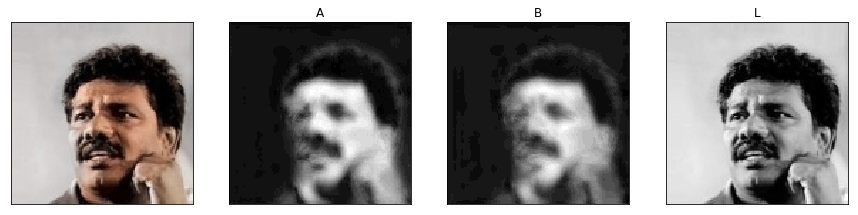

predy 126.97611 154.48955 137.20164 (1, 128, 128, 2)
hue: 127.130196 152.32861 135.69818
sat: 126.97611 154.48955 138.70511
predy uint8 126 154 136.68048095703125
hue uint8 127 152 135.16357421875


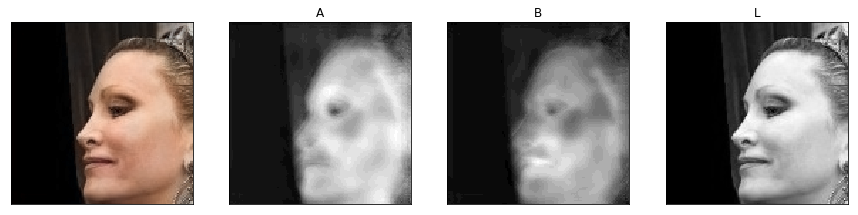

predy 123.97795 155.23529 135.99399 (1, 128, 128, 2)
hue: 126.16306 155.2134 135.29654
sat: 123.97795 155.23529 136.69145
predy uint8 123 155 135.49880981445312
hue uint8 126 155 134.8082275390625


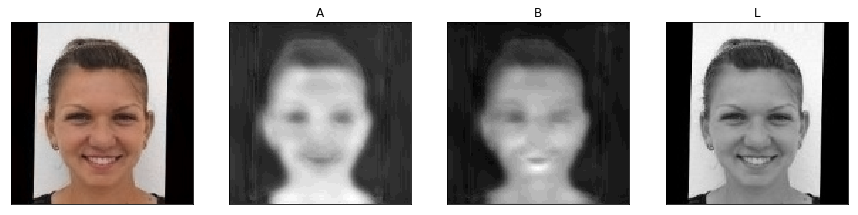

predy 125.28619 158.71371 135.35132 (1, 128, 128, 2)
hue: 127.58414 158.71371 135.00179
sat: 125.28619 158.15489 135.70088
predy uint8 125 158 134.85678100585938
hue uint8 127 158 134.506103515625


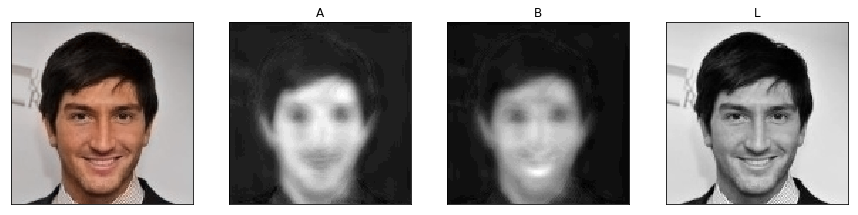

predy 126.55889 160.76398 135.7134 (1, 128, 128, 2)
hue: 127.19318 160.76398 134.80502
sat: 126.55889 155.02295 136.62177
predy uint8 126 160 135.2103271484375
hue uint8 127 160 134.30059814453125


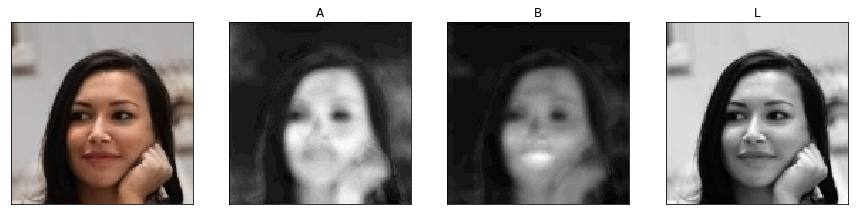

predy 127.392525 160.20045 137.08287 (1, 128, 128, 2)
hue: 127.457054 160.20045 136.0776
sat: 127.392525 154.73346 138.08813
predy uint8 127 160 136.5810546875
hue uint8 127 160 135.57666015625


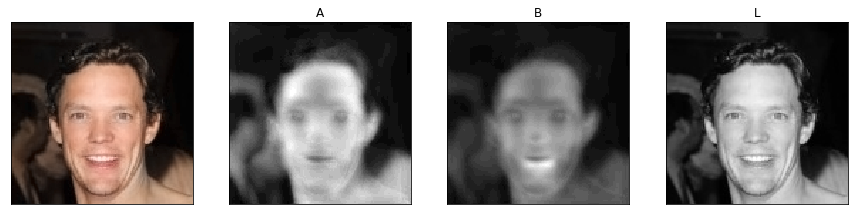

predy 127.20586 157.2965 134.59363 (1, 128, 128, 2)
hue: 127.20586 154.72571 133.9077
sat: 127.49632 157.2965 135.27957
predy uint8 127 157 134.08355712890625
hue uint8 127 154 133.40087890625


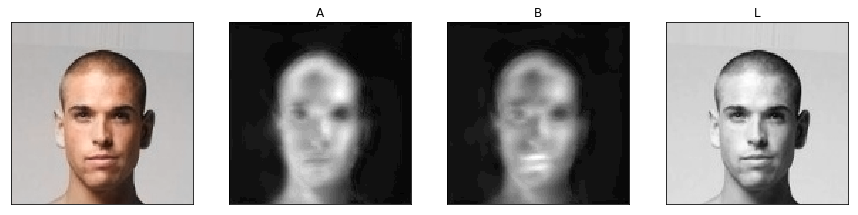

predy 124.51659 155.90213 134.06136 (1, 128, 128, 2)
hue: 127.07207 151.90839 133.37637
sat: 124.51659 155.90213 134.74632
predy uint8 124 155 133.55838012695312
hue uint8 127 151 132.87786865234375


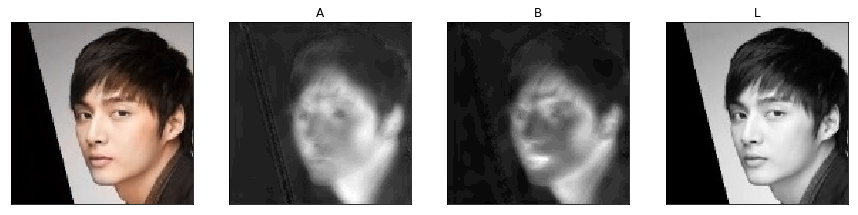

predy 127.84223 154.60095 135.11755 (1, 128, 128, 2)
hue: 127.84223 154.60095 134.1665
sat: 128.34499 150.1299 136.06863
predy uint8 127 154 134.6116943359375
hue uint8 127 154 133.65972900390625


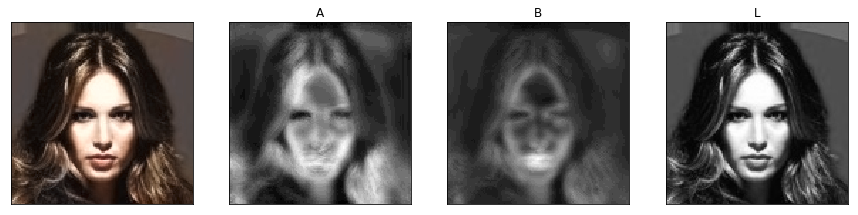

predy 125.08631 156.4084 135.72943 (1, 128, 128, 2)
hue: 125.08631 156.4084 134.81578
sat: 126.369354 155.93114 136.64308
predy uint8 125 156 135.24411010742188
hue uint8 125 156 134.34259033203125


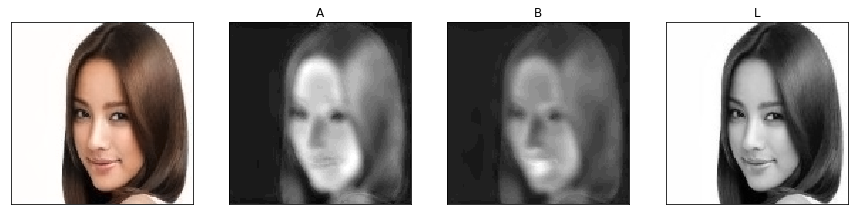

predy 126.96092 153.23697 136.52086 (1, 128, 128, 2)
hue: 127.1157 153.23697 135.80484
sat: 126.96092 151.7113 137.23688
predy uint8 126 153 136.00238037109375
hue uint8 127 153 135.28973388671875


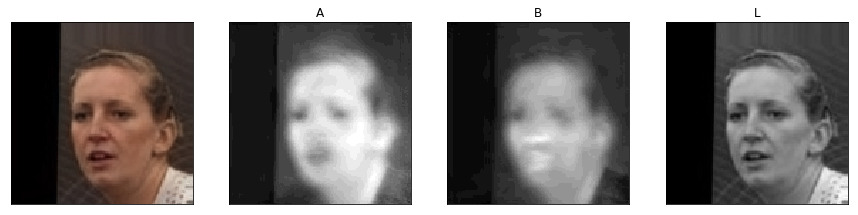

predy 127.373344 153.78702 136.99017 (1, 128, 128, 2)
hue: 127.373344 149.65292 136.0527
sat: 127.60201 153.78702 137.92766
predy uint8 127 153 136.48495483398438
hue uint8 127 149 135.54656982421875


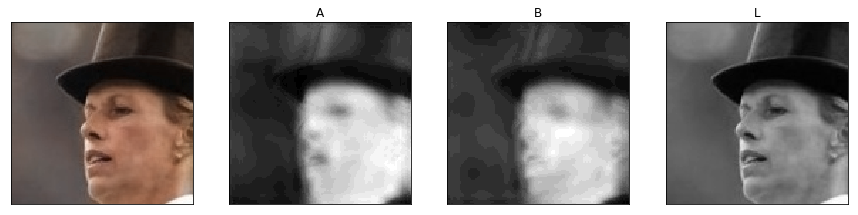

predy 126.70984 154.0278 137.48407 (1, 128, 128, 2)
hue: 126.77344 149.82855 135.59134
sat: 126.70984 154.0278 139.3768
predy uint8 126 154 136.98959350585938
hue uint8 126 149 135.099365234375


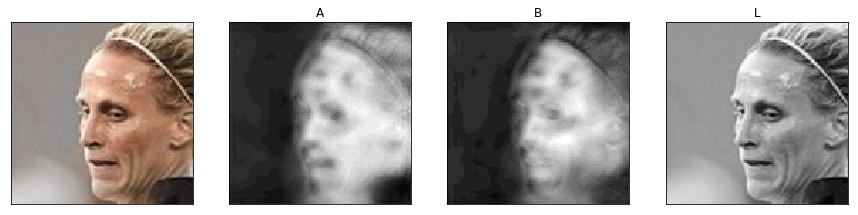

predy 121.4063 151.19664 133.85364 (1, 128, 128, 2)
hue: 125.32006 151.03885 133.41882
sat: 121.4063 151.19664 134.28847
predy uint8 121 151 133.3626708984375
hue uint8 125 151 132.9273681640625


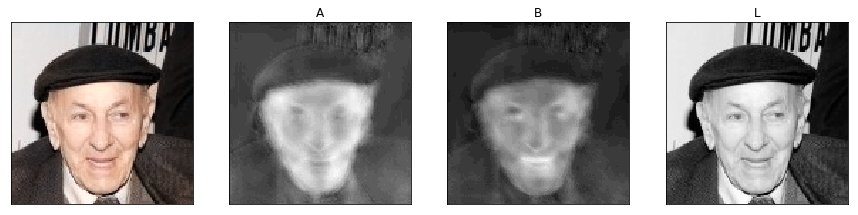

In [181]:
print('countEpochs',countEpochs)
predictions(trainSize, 40)


In [ ]:
def nonMlBaseline():
    x = training_generator[33][0][0,...,0]
    y = np.dstack([params['mean'][...,0].astype('uint8'), params['mean'][...,1].astype('uint8'), x.astype('uint8')])
    #print(y.shape, params['mean'][...,0].min(), params['mean'][...,0].max(), x.dtype, x.min(), x.max())
    # plt.imshow(x - params['mean'][...,2])
    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['hue','saturation','value'][i-1])
        plt.imshow(params['mean'][...,i-1])
    plt.show()
    print("Input value with mean hue and mean saturation:")
    showHsv(y)
nonMlBaseline()

In [ ]:
print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

In [ ]:
model.save(f'data/{NAME}.h5')

In [ ]:
print(training_generator[0][0][0,...,0].shape)
print('sanity check - mean[...,2] is val mean:')
ttt =(training_generator[0][0][6,...,0] - params['mean'][...,2]  ) / np.sqrt(params['var'][...,2])
plt.imshow(ttt) 
ttt.min(), ttt.max(), ttt.mean()

In [ ]:
print('mean hue, saturation, value:')
h,s,v = params['mean'][...,0], params['mean'][...,1], params['mean'][...,2]
showHsv(np.dstack([h,s,v]).astype('uint8'))
for i,c in enumerate([h,s,v]):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(c)

plt.show()


In [ ]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
batch=55
print('testing channel ranges:')
print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
print(training_generator[batch][1].shape)
h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
v = training_generator[batch][0][0,...].astype('uint8')
y = np.dstack([h , s, v ] )
showHsv(y )
print(h.min(), h.max())
plt.imshow(h)

In [ ]:
x1w = model.get_weights()[0][:,:,0,:]
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [121]:
def demo(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (128,128))
    cv2.imwrite("./tmp.jpg", img)
    predictFromImage("./tmp.jpg", True)
    try:
        os.remove("./tmp.jpg")
    except OSError:
        pass
